In [1]:
# import libraries

# data preprocessing libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

# model libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
import keras_tuner as kt 

# model evaluation libraries
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.inspection import permutation_importance

## Data Source

https://www.kaggle.com/datasets/rangalamahesh/bank-churn

In [2]:
# import data from csv and convert to dataframe
df_1 = pd.read_csv('train.csv')
df_2 = pd.read_csv('test.csv')

# data was supplied already split into test and train. recombine here for cleaning and visualization
df = pd.concat([df_1, df_2])
df.head(5)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0.0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0.0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0.0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0.0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0.0


## Data Cleaning

In [3]:
# Checking data types
df.dtypes

id                   int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited             float64
dtype: object

In [3]:
# Drop unwanted columns
df = df.drop(columns=['CustomerId', 'id', 'Surname'])

# Check columns were dropped
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [4]:
# Checking for nulls
df.isnull().sum().sum()

110023

In [5]:
# Drop nulss and recheck
df = df.dropna()
df.isnull().sum().sum()

0

In [6]:
# Target column is float64. Casting as int
df['Exited'] = df['Exited'].astype(int)
df['Exited'].dtype

dtype('int32')

In [7]:
# Export as csv for use in Tableau
df.to_csv('cleaned_data.csv', index=False)

## Machine Learning - Preprocessesing

In [8]:
# Look at Target_Churn value counts for balance
classification_counts = df['Exited'].value_counts()
classification_counts

Exited
0    130113
1     34921
Name: count, dtype: int64

In [9]:
# Convert categorical data to numeric with `pd.get_dummies`
df = pd.get_dummies(df)
df.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 'Geography_France',
       'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male'],
      dtype='object')

In [10]:
# Split our preprocessed data into our features and target arrays
X = df.drop('Exited', axis = "columns")
y = df['Exited']

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [11]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Logistic Regression: Compile, Train and Evaluate the Model

In [12]:
# create logistic regression model instance
classifier = LogisticRegression(solver='lbfgs', random_state=1)

# Train the data
classifier.fit(X_train_scaled, y_train)

# Make a prediction using the testing data
predictions = classifier.predict(X_test_scaled)

# Generate a confusion matrix for the model
confusion_matrix(y_test, predictions)

# Print the classification report for the model
target_names = ["churn_false", "churn_true"]
print(classification_report(y_test, predictions, target_names=target_names))

              precision    recall  f1-score   support

 churn_false       0.85      0.95      0.90     32568
  churn_true       0.69      0.38      0.49      8691

    accuracy                           0.83     41259
   macro avg       0.77      0.67      0.70     41259
weighted avg       0.82      0.83      0.81     41259



Text(0.5, 1.0, 'Permutation Importance')

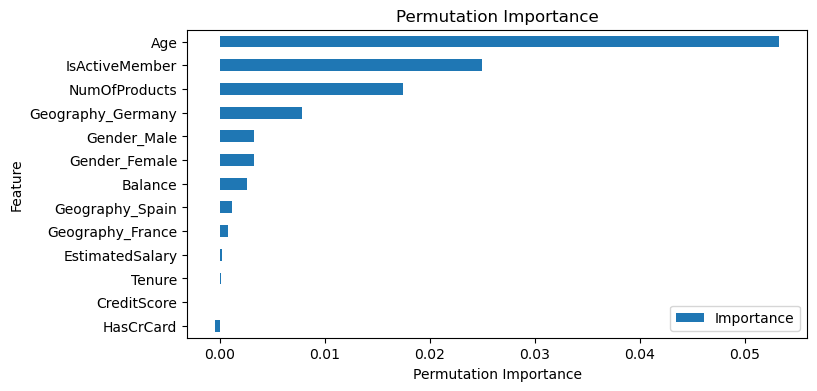

In [13]:
# checking feature importance

result = permutation_importance(classifier, X_test_scaled, y_test, n_repeats=10, random_state=42)


feature_importance = pd.DataFrame({'Feature': X.columns,
                                   'Importance': result.importances_mean,})
feature_importance = feature_importance.sort_values('Importance', ascending=True)


ax = feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(8, 4), capsize=4)
ax.set_xlabel('Permutation Importance')
ax.set_title('Permutation Importance')

## Logistic Regression with RandomOverSampling Compile, Train and Evaluate the Model

              precision    recall  f1-score   support

 churn_false       0.77      0.83      0.80     32484
  churn_true       0.74      0.67      0.70     24441

    accuracy                           0.76     56925
   macro avg       0.76      0.75      0.75     56925
weighted avg       0.76      0.76      0.76     56925



Text(0.5, 1.0, 'Permutation Importance')

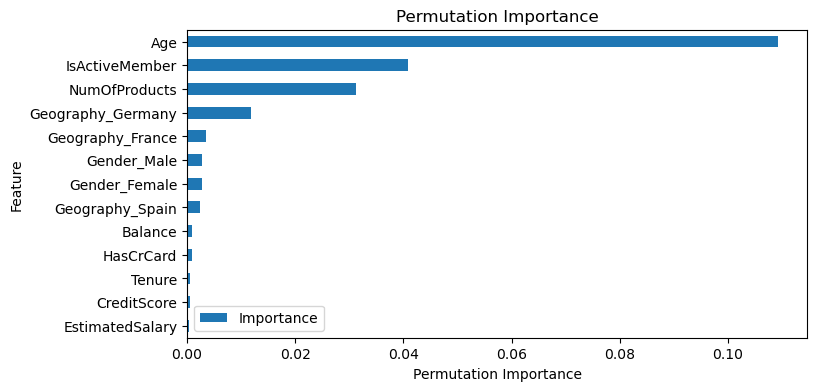

In [17]:
# Split our preprocessed data into our features and target arrays
X = df.drop('Exited', axis = "columns")
y = df['Exited']

# Define oversampling strategy
oversample = RandomOverSampler(sampling_strategy=0.75)

# Fit and apply the transform
X_over, y_over = oversample.fit_resample(X, y)

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, random_state=78)

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# create logistic regression model instance
classifier = LogisticRegression(solver='lbfgs', random_state=1)

# Train the data
classifier.fit(X_train_scaled, y_train)

# Make a prediction using the testing data
predictions = classifier.predict(X_test_scaled)

# Generate a confusion matrix for the model
confusion_matrix(y_test, predictions)

# Print the classification report for the model
target_names = ["churn_false", "churn_true"]
print(classification_report(y_test, predictions, target_names=target_names))

# checking feature importance

result = permutation_importance(classifier, X_test_scaled, y_test, n_repeats=10, random_state=42)


feature_importance = pd.DataFrame({'Feature': X.columns,
                                   'Importance': result.importances_mean,})
feature_importance = feature_importance.sort_values('Importance', ascending=True)


ax = feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(8, 4), capsize=4)
ax.set_xlabel('Permutation Importance')
ax.set_title('Permutation Importance')

## Random Forest: Compile, Train and Evaluate the Model

In [15]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

# Generate a confusion matrix for the model
confusion_matrix(y_test, predictions)

# Print the classification report for the model
target_names = ["churn_false", "churn_true"]
print(classification_report(y_test, predictions, target_names=target_names))


              precision    recall  f1-score   support

 churn_false       0.89      0.94      0.91     32568
  churn_true       0.71      0.54      0.62      8691

    accuracy                           0.86     41259
   macro avg       0.80      0.74      0.76     41259
weighted avg       0.85      0.86      0.85     41259



## SVM: Compile, Train and Evaluate the Model

In [16]:
# Create a SVC linear model
model = SVC(kernel='rbf')

# Fit to the training data and validate with the test data
model.fit(X_train_scaled, y_train)
predictions = model.predict(X_test_scaled)

# Generate a confusion matrix for the model
confusion_matrix(y_test, predictions)

# Print the classification report for the model
target_names = ["churn_false", "churn_true"]
print(classification_report(y_test, predictions, target_names=target_names))

              precision    recall  f1-score   support

 churn_false       0.88      0.96      0.92     32568
  churn_true       0.77      0.49      0.60      8691

    accuracy                           0.86     41259
   macro avg       0.82      0.72      0.76     41259
weighted avg       0.85      0.86      0.85     41259



## KNN: Compile, Train and Evaluate the Model

In [22]:
# Instantiate the model with k = 3 neighbors
model = KNeighborsClassifier(n_neighbors=5)

# Train the model
model.fit(X_train_scaled, y_train)

# Create predictions
predictions = model.predict(X_test_scaled)

# Generate a confusion matrix for the model
confusion_matrix(y_test, predictions)

# Print the classification report for the model
target_names = ["churn_false", "churn_true"]
print(classification_report(y_test, predictions, target_names=target_names))

              precision    recall  f1-score   support

 churn_false       0.88      0.93      0.91     32568
  churn_true       0.67      0.54      0.60      8691

    accuracy                           0.85     41259
   macro avg       0.78      0.73      0.75     41259
weighted avg       0.84      0.85      0.84     41259



## Neural Network: Compile, Train and Evaluate the Model

In [16]:
# define number of input features

num_input_features = len(X_train_scaled[0])

# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh'])
    
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=10,
        max_value=50,
        step=5), activation=activation, input_dim=num_input_features))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 5)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=10,
            max_value=50,
            step=5),
            activation=activation))
    
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model

In [17]:
# Define the kerastuner

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2,
    overwrite = True
    )

# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

# Get top 3 model hyperparameters and print the values
top_hyper = tuner.get_best_hyperparameters(3)
for param in top_hyper:
    print(param.values)

Trial 54 Complete [00h 01m 32s]
val_accuracy: 0.8640539050102234

Best val_accuracy So Far: 0.8652657866477966
Total elapsed time: 01h 01m 54s

Search: Running Trial #55

Value             |Best Value So Far |Hyperparameter
relu              |relu              |activation
40                |35                |first_units
2                 |4                 |num_layers
15                |10                |units_0
25                |40                |units_1
15                |50                |units_2
50                |15                |units_3
45                |15                |units_4
20                |20                |tuner/epochs
7                 |0                 |tuner/initial_epoch
1                 |0                 |tuner/bracket
1                 |0                 |tuner/round
0050              |None              |tuner/trial_id

Epoch 8/20
3868/3868 [==============================] - 15s 3ms/step - loss: 0.3229 - accuracy: 0.8642 - val_loss: 0.3266 - val_accur

KeyboardInterrupt: 